<a href="https://colab.research.google.com/github/Codehackerone/nlp-with-transformers/blob/main/Sentiment_Classification_with_Transformers(TF).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting the data


In [11]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [12]:
!rm .kaggle
!mkdir .kaggle

rm: cannot remove '.kaggle': No such file or directory


In [13]:
%mv kaggle.json /content/.kaggle

mv: cannot stat 'kaggle.json': No such file or directory


In [14]:
!sudo mv .kaggle /root/

mv: cannot move '.kaggle' to '/root/.kaggle': Directory not empty


In [15]:
import kaggle

In [16]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [17]:
api = KaggleApi()

In [18]:
api.authenticate()

In [19]:
api.competition_download_file('sentiment-analysis-on-movie-reviews',
                              'test.tsv.zip', path='/content/')

100%|██████████| 494k/494k [00:00<00:00, 37.5MB/s]

In [20]:
api.competition_download_file('sentiment-analysis-on-movie-reviews',
                              'train.tsv.zip', path='/content/')

100%|██████████| 1.28M/1.28M [00:00<00:00, 107MB/s]

In [21]:
import zipfile

In [22]:
with zipfile.ZipFile('./test.tsv.zip', 'r') as zipref:
  zipref.extractall('./')

In [23]:
with zipfile.ZipFile('./train.tsv.zip', 'r') as zipref:
  zipref.extractall('./')

# Preprocessing

In [24]:
import pandas as pd

In [25]:
df = pd.read_csv('train.tsv', sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [26]:
# df.drop_duplicates(subset=['SentenceId'], keep='first')

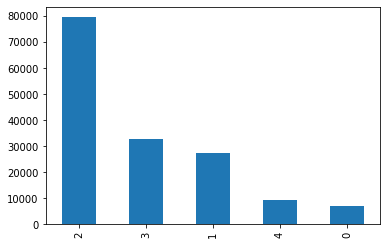

In [27]:
df['Sentiment'].value_counts().plot(kind='bar')

In [28]:
seq_length = 512
num_samples = len(df)

num_samples, seq_length

(156060, 512)

In [29]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.5 MB/s 
     |████████████████████████████████| 6.6 MB 40.6 MB/s 
     |████████████████████████████████| 596 kB 57.0 MB/s 
     |████████████████████████████████| 101 kB 10.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [30]:
from transformers import BertTokenizer

In [31]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [32]:
tokens = tokenizer(df['Phrase'].tolist(), max_length=seq_length,
                   truncation=True, padding='max_length',
                   add_special_tokens=True, return_tensors='np')

In [33]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [34]:
tokens['input_ids']

array([[  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       ...,
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101, 22572, 12148, ...,     0,     0,     0]])

In [35]:
tokens['attention_mask']

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [36]:
import numpy as np

with open('movie-xids.npy', 'wb') as f:
  np.save(f, tokens['input_ids'])
with open('movie-xmask.npy', 'wb') as f:
  np.save(f, tokens['attention_mask'])

In [37]:
arr = df['Sentiment'].values

In [38]:
arr.shape

(156060,)

In [39]:
arr.max() + 1

5

In [40]:
labels = np.zeros((num_samples, arr.max()+1))

In [41]:
labels[np.arange(num_samples), arr] = 1

In [42]:
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [43]:
with open('movie-labels.npy', 'wb') as f:
  np.save(f, labels)

# Building a Dataset

In [44]:
with open('movie-xids.npy', 'rb') as f:
  Xids = np.load(f, allow_pickle=True)
with open('movie-xmask.npy', 'rb') as f:
  Xmask = np.load(f, allow_pickle=True)
with open('movie-labels.npy', 'rb') as f:
  labels = np.load(f, allow_pickle=True)

In [45]:
Xids.shape

(156060, 512)

In [46]:
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [47]:
import tensorflow as tf

In [48]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

In [49]:
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [50]:
# {input_ids, attention_mask}, outputs

In [51]:
def map(input_ids, masks, labels):
  return {'input_ids':input_ids,'attention_mask':masks}, labels

In [52]:
dataset = dataset.map(map)

In [53]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int64, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

# Dataset Shuffle, Batch, Split, Save

In [54]:
batch_size = 16

In [55]:
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

In [56]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [57]:
split = 0.9

In [58]:
size = Xids.shape[0]

In [59]:
size = int((Xids.shape[0]/batch_size) * split)

In [60]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

In [61]:
tf.data.experimental.save(train_ds, 'train')
tf.data.experimental.save(val_ds, 'val')

In [62]:
train_ds.element_spec

({'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
  'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [63]:
val_ds.element_spec

({'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
  'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [64]:
ds = tf.data.experimental.load('train', element_spec=train_ds.element_spec)

In [65]:
ds.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

# Build and Save Model

In [66]:
from transformers import TFAutoModel

In [67]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [68]:
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [69]:
# two_inputs 
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

# transformer
embeddings = bert.bert(input_ids, attention_mask=mask)[1]

# classification head
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

In [70]:
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

In [71]:
model.layers[2].trainable = False

In [72]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [73]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.Accuracy()

model.compile(optimizer, loss=loss, metrics=[acc])

In [102]:
element_spec = train_ds.element_spec

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1
)

In [74]:
model.save('sentiment_model.h5')

# Load and Predict

In [76]:
model = tf.keras.models.load_model('sentiment_model.h5')

In [77]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [80]:
def prep_data(text):
  tokens = tokenizer(text, max_length=seq_length,
                   truncation=True, padding='max_length',
                   add_special_tokens=True, return_tensors='tf')
  return {'input_ids':tokens['input_ids'],'attention_mask':tokens['attention_mask']}

In [81]:
prep_data('hello world')

{'attention_mask': <tf.Tensor: shape=(1, 512), dtype=int32, numpy=
 array([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 

In [82]:
probs = model.predict(prep_data('hello world'))[0]

probs

array([0.2876781 , 0.2853206 , 0.19665366, 0.08084184, 0.14950585],
      dtype=float32)

In [83]:
import numpy as np

In [84]:
np.argmax(probs)

0

In [85]:
def predict(text):
  probs = model.predict(prep_data('hello world'))[0]
  return np.argmax(probs)

In [86]:
predict('this is ammaazing')

0

In [87]:
predict('not cool at all')

0

In [88]:
df = pd.read_csv('test.tsv', sep='\t')

In [90]:
df = df.drop_duplicates(subset=['SentenceId'], keep='first')

In [91]:
df.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
15,156076,8546,Kidman is really the only thing that 's worth ...
93,156154,8547,Once you get into its rhythm ... the movie bec...
117,156178,8548,I kept wishing I was watching a documentary ab...
158,156219,8549,"Kinnear does n't aim for our sympathy , but ra..."


In [92]:
df['Sentiment'] = None

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
for i, row in df.iterrows():
  tokens = prep_data(row['Phrase'])
  probs = model.predict(tokens)
  pred = np.argmax(probs)
  df.at[i, 'Sentiment'] = pred

In [ ]:
df.head()